<img src ="Logo.jpg" alt ="nf-core" width="500" height="500">

## Special Topics in Applied Systems Biology

## Proteomics Data Analysis Overview

### Introduction 

This document outlines the essential steps in the process of analyzing proteomics data for the NIGMS National Resource for Quantitative Proteomics, and recommends commonly used tools and techniques for this purpose. It is assumed in this document that the experimental design is simple and that differential expression is being assessed between 2 experimental conditions, i.e. a simple 1:1 comparison, with some information about analyzing data from complex experimental designs. The focus of the SOP is on Tandem Mass Tag multiplex designs as well as Data Independent Acquistion data. This document describes the Data preprocessing, normalization, and differential abundance analysis. The minimum recommended biological replicates for each sample condition is 5. The number of replicates should be increased for more complex study designs.  

#### Note: This notebook uses simple base R plots. These can be modified to learn how to build better publication quality plots.

### Basic Steps 
1. Database search using Mascot, MaxQuant, or Prosit/EncylopeDIA
2. Assess the sample variance, biological replicate correlation, and data distributions using ProtieNorm
3. Perfom data normalization using the method with the lowest variance and highest intra-group correlation. For the majority of cases, VSN and Cyclic Loess have performed well. 
4. Plot quality control figures such as PCA and clustered dendrograms to check for outlier samples. These plots will give an indication of the effect size in the data. How many proteins do we expect to be differenitally expressed? 
5. Set up the limma model and run analysis. The model should consider factors such as batch, sex, age, if the samples are paired, etc. 
6. Plot the results using Volcano and/or MD plots. 

<img src ="WorkFlow_figure.png" alt="workflow" width="700" height = "700">

### Glossary of Terms


<b> MaxQuant: </b> a quantitative proteomics software package designed for analyzing large mass-spectrometric data sets. It is specifically aimed at high-resolution MS data. Several labeling techniques as well as label-free quantification are supported. MaxQuant is freely available at maxquant.org

<b> Tandem Mass Tag (TMT):</b> Thermo Scientific Tandem Mass Tag Reagents are designed to enable identification and quantitation of proteins in different samples using tandem mass spectrometry (MS). All mass tagging reagents within a set have the same nominal mass (i.e., are isobaric) and chemical structure composed of an amine-reactive NHS ester group, a spacer arm (mass normalizer), and a mass reporter. The standard tandem mass tag (TMT) labeling kits and reagents enable multiplex (6-plex to 11-plex) relative quantitation using high-resolution MS for samples prepared from cells or tissues.

<b> Multinotch MS3: </b> We fragment the aggregate MS3 precursor population (i.e., MultiNotch MS3) to produce a reporter ion population that is far more intense than the population we would have produced had we only fragmented a single MS2 ion. At the same time, we maintain the selectivity of the standard MS3 method by carefully defining the isolation notches of the SPS isolation waveform to ensure high isolation specificity of the target MS2 fragment ions.(McAlister et al. 2014)

<b> Data-dependent acquistion (DDA): </b> Only selected peptides are further fragemented during the second stage of tandem MS. These selected peptides are chosen within narrow range of mass-to-charge (m/z) signal intensity. Typically, the precursors of highest abundance, "top N" precursors, are selected for further analysis. MS/MS data acquistion occurs sequentially for each peptide. The resulting data is searched using existing databases. Allows relative quantification of peptides between samples. Challenges: DDA can contain "gaps" where peptides have been identified in some samples only. Low-abundance peptides are under-represented. 

<b> Data Independent Acquistion (DIA): </b> the mass spectrometer systematically acquires MS/MS spectra irrespective of whether or not a precursor signal is detected. All peptides are fragmented and analyzed during the second stage of tandem MS. MS/MS spectra are acquired either by fragmenting all ions that enter the mass spectrometer at a given time, called broadband DIA, or by sequentially focusing on a narrow m/z window of precursors and fragmenting all precursors detected within that window. MS/MS data acquistion occurs in parallel across peptides. Resulting MS spectra are highly multiplexed!  

The DIA workflow has been adopted from Brian Seerly's group. 

"Typically tens to hundreds of biological samples are processed and analyzed using LC-MS/MS in quantitative proteomics experiments.  These runs can be searched using either a typical DDA spectrum library-based workflow or a pure DIA workflow using PECAN, or spectrum-centric search methods based on DIA-Umpire or Spectronaut Pulsar. Results from runs dedicated to peptide detection are formed into a DIA-based chromatogram library. In a chromatogram library, we catalog retention time, precursor mass, peptide fragmentation patterns, and known interferences that identify each peptide on our instrumentation within a specific sample matrix. Furthermore, we report the development EncyclopeDIA, a library search engine that takes advantage of chromatogram libraries, and we demonstrate a substantial gain in sensitivity over typical DIA and DDA workflows. "


<b> Normalization: </b> to remove technical and biological sources of unwanted variation

<b> Missing Values: </b> a protein with a zero abundance indicates the protein was not identified in that sample 

<b> Batch effect: </b> occurs when non-biological factors in an experiment cause changes in the data produced by the experiment. Such effects can lead to inaccurate conclusions. Examples include multiple TMT batches, sex, samples that were prepared on different days, etc. 

<b> logfc: </b> estimate of the Log2 fold change corresponding to the contrast (group comparison)

<b> FDR p-value: </b> False discovery rate adjusted p-value for multiple test correction. FDR determines adjusted p-values for each test. A p-value of 0.05 implies that 5% of all <b> tests </b> will result in false positives. An FDR adjusted p-value (or q-value) of 0.05 implies that 5% of <b> significant tests </b> will result in false positives. The latter will result in fewer false positives.

# Step 1. Quality Control and data pre-processing

## Steps for Data pre-processing

1. Database search results from MaxQuant are loaded into proteiNorm to identify sample outliers and evalute the best normalization method for the data set.
2. The proteinGroups.txt file is filtered for proteins that match a contaminants database or are reverse sequences. 
3. Outlier samples can be removed
4. Proteins can be filtered by requireing at least 2/3 of the replicates within one sample group to have a value. This removes proteins that are missing in most or all of the samples.
5. Evaluation metrics are evaluated and the normalization method that provides the highest intra-group correlation and the lowest variance is the method of choice. For the majority of data sets, VSN and cyclic loess have performed the best. 
6. The normalized protein abundance file is exported and becomes the input for the Differential Abundance Analysis. 
7. QC plots include PCA, dendrograms, violin plots, and a clustered heatmap of all identified proteins is included. These figures help to identify any batch effects such as TMT batch and gender effects.  

## Evaluation of normalization methods

The most common quantitative measures are <b>standard deviation (SD) , coefficient of variation (CV), median absolute deviation (MAD), and pooled estimate of variance (PEV). </b>
<ul>
    <li> SD can be either positive or negative and is described relative to the sample mean, making it difficult to compare samples with differing mean. Measuring PEV could be an alternative for comparisons as it is always positive. </li>
     <li> CV measures variation as a percentage of mean and thus can be expressed independently of the mean, making it easier to compare variability between samples. However, CV is highly sensitive when the sample mean is close to zero as even low variation could produce high CV. Moreover, SD, PEV, and CV are sensitive to outliers. </li>
     <li>  MAD measures the median of the absolute deviations around the sample median and thus is more robust and less sensitive to outliers. These methods were used previously for normalization evaluation of omics data. </li>
    <li> Qualitative evaluation can be based on boxplots, MA plots, dendrograms, or correlation plots. </li>
     <li> Optimally, a normalization method for a given data set should be selected on the basis of both quantitative and qualitative evaluation measures and by further analysis of previously known housekeeping genes or proteins (Chawade et al. 2014).</li>
        
</ul>        


## terms for Normalization

<b> Pooled variance: </b>  (also known as combined variance, composite variance, or overall variance, is a method for estimating variance of several different populations when the mean of each population may be different, but one may assume that the variance of each population is the same. The numerical estimate resulting from the use of this method is also called the pooled variance. Under the assumption of equal population variances, the pooled sample variance provides a higher precision estimate of variance than the individual sample variances.

<b> intra-group correlations: </b> describes how strongly units in the same group resemble each other. While it is viewed as a type of correlation, unlike most other correlation measures it operates on data structured as groups, rather than data structured as paired observations.

<b> variance stabilizing normalization (VSN):</b> The method uses a robust variant of the maximum-likelihood estimator for an additive-multiplicative error model and affine calibration. The model incorporates data calibration step (a.k.a. normalization), a model for the dependence of the variance on the mean intensity and a variance stabilizing data transformation. Differences between transformed intensities are analogous to "normalized log-ratios". However, in contrast to the latter, their variance is independent of the mean, and they are usually more sensitive and specific in detecting differential transcription (Huber et al. 2002)

<b> Cyclic Loess: </b> Normalize the columns of a matrix, cyclicly applying loess normalization to normalize each pair of columns to each other. For example, if we see in an MA-plot a non-linear bias in the M that changes as function of A; the general idea behind loess normalization is to estimate this bias and remove it. Because the bias is a curve of no obvious parametric form (it is not a line or parabola or a sine function, etc.) we want to fit a curve to the data. Local weighted regression (loess) provides one way to do this. Loess is inspired by Taylor’s theorem that in practice means that at any given point, if one looks at a small enough region around that point, the curve looks like a parabola. If you look even closer it looks like a straight line (note that gardeners can make a curved edge with a straight shovel).

Loess takes advantage of this mathematical property of functions. For each point in your data set a region is defined considered to be small enough to assume the curve approximated by a line in that region and a line is fit with weighted least squares. The weights depend on the distance from the point of interest. The robust version of loess also weights points down that are considered outliers. (http://genomicsclass.github.io/book/pages/normalization.html)

## how to handle missing values

Missing values are not imputed if at all possible. DIA helps limit the number of missing values when more than 16 samples are included in an analysis. However, limma handles any missing values in the data as follows: 

When fitting protein-wise linear models in limma using lmFit(), missing values are removed from the response vector of the log-ratios, and the corresponding row/s of the design matrix are removed before the linear model is fitted to each protein. Missing values in limma are treated the same as the <b> lm() </b> function with <b> na.action=na.omit </b>. It doesn’t mind NAs coming in, but corrects the degrees of freedom depending on the number of missing values for each protein. 

## ProteiNorm Evaluation
### intra-group correlation
#### High intragroup correlation values indicate high correlation of replicates within treatment groups and are desirable.   

<img src="proteinorm/COR.png" alt="correlation" width="400" height="400" >
<b>Figure 1: Correlation Plot.</b> Shows all pair-wise intra-group correlations for different normalization methods.                                                                

### Variation of sample replicates
#### Small values are desirable as they indicate limited variation of sample replicates.

<img src="proteinorm/PCV_PEV_PMAD.png" alt="PCV" width="1000" height="1000" >

<b>Figure 2: PCV, PMAD, PEV.</b> Pooled coefficient of variation (PCV), pooled median absolute difference (PMAD), pooled estimate of variance (PEV) are measurements of intragroup variations. 


In [1]:
# load libraries

library(readr)
library(matrixStats)
library(tidyverse)
#library(pheatmap)
library(ComplexHeatmap)
library(ggfortify)
library(sva)
library(edgeR)
library(RColorBrewer)
library(pls)
library(colorspace)


Warning message:
"package 'readr' was built under R version 4.0.3"
Warning message:
"package 'matrixStats' was built under R version 4.0.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v dplyr   1.0.3
v tibble  3.0.5     v stringr 1.4.0
v tidyr   1.1.2     v forcats 0.5.0
v purrr   0.3.4     

Warning message:
"package 'ggplot2' was built under R version 4.0.3"
Warning message:
"package 'tibble' was built under R version 4.0.3"
Warning message:
"package 'dplyr' was built under R version 4.0.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::count()  masks matrixStats::count()
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'ComplexHeatmap' was built under R version 4.0.3"
Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jok

ERROR: Error in library(sva): there is no package called 'sva'


In [2]:
# Set colors for plots

# colors 
orange <- "#f2ab07"
green <- "#35a562"
green2 <- "#0ee2d7"
red <- "#e20d26"
blue <- "#0f0fe2"

## Example data: the data has been normalized using Cyclic Loess. 
The input file contains both the normalized MS3 protein intensities as well as the sample names, group, and batch information in the same input file. Normally, the "metafile" and "data" would be imported separately and evaluated using proteiNorm in the proteomicsDIA R package. 

In [3]:
## Load in data 
# set the Group column as factors

# Data normalized by ProteiNorm using Cyclic Loess
# contains sample information and protein values in one matrix
TMT1 <- read_csv("Byrum_ProteiNorm_cyclicLoess_Rinput2_meta.csv", col_types = cols(Group = col_factor(levels = c("0","1","2","3","4","5"))))


### boxplot

A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can tell you about your outliers and what their values are. It can also tell you if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed.

For some distributions/datasets, you will find that you need more information than the measures of central tendency (median, mean, and mode). You need to have information on the variability or dispersion of the data. A boxplot is a graph that gives you a good indication of how the values in the data are spread out.

<img src="https://miro.medium.com/max/1400/1*NRlqiZGQdsIyAu0KzP7LaQ.png" alt="boxplot" width="600" height="600">
Reference= https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51


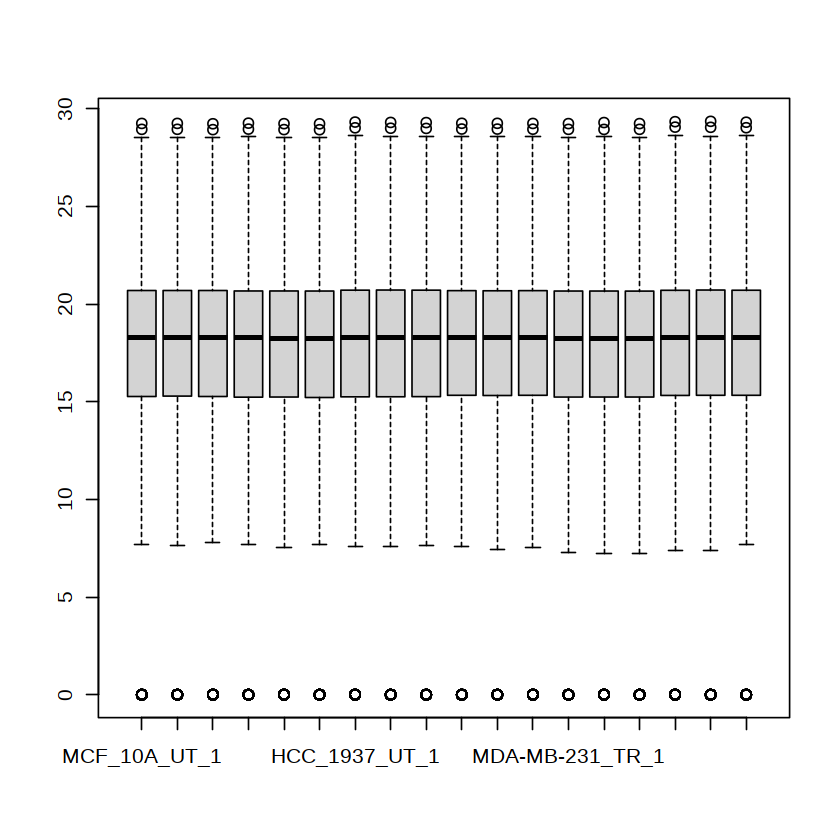

In [4]:
# Boxplot of samples protein intensities
######## individual TMT batch
datTMT1 <- as.data.frame(TMT1)
row.names(datTMT1) <- datTMT1$Sample
boxplot(t(datTMT1[1:nrow(datTMT1), 6:ncol(datTMT1)]))


## Histogram plot
Graphs that display the distribution of your continuous data. They are fantastic exploratory tools because they reveal properties about your sample data in ways that summary statistics cannot. For instance, while the mean and standard deviation can numerically summarize your data, histograms bring your sample data to life.

We often use summary statistics to describe an entire dataset. These statistics use a single number to quantify a characteristic of the sample. For example, a measure of central tendency is a single value that represents the center point or typical value of a dataset, such as the mean. A measure of variability is another type of summary statistic that describes how spread out the values are in your dataset. The standard deviation is a conventional measure of dispersion.

identifying the shape of your distribution. The shape of the distribution is a fundamental characteristic of your sample that can determine which measure of central tendency best reflects the center of your data. Relatedly, the shape also impacts your choice between using a parametric or nonparametric hypothesis test. In this manner, histograms are informative about the summary statistics and hypothesis tests that are appropriate for your data.

<b> Below you will see a large number of proteins with a normalized intensity of zero. These are the missing proteins most likely from the TMT batch effect. </b>

Reference: https://statisticsbyjim.com/basics/histograms/

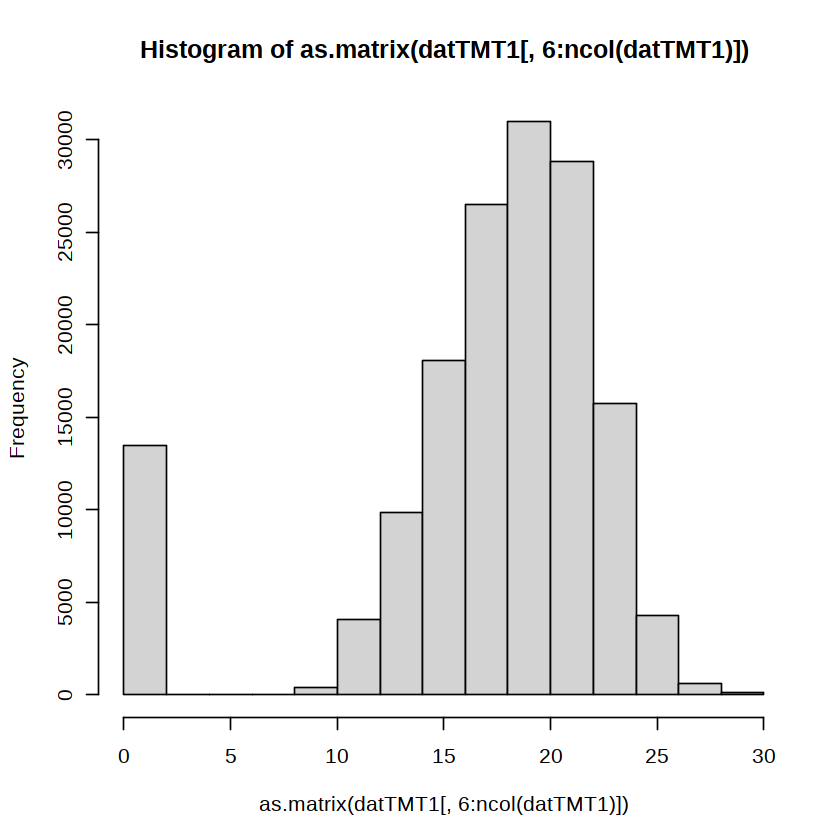

In [5]:
# Check the protein distribution
hist(as.matrix(datTMT1[, 6:ncol(datTMT1)]))

In [6]:
#######################################################################
########## Check Correlation of samples and Coefficient of Variation

# individual TMTs 
Pearson <- cor(t(datTMT1[,6:ncol(datTMT1)]), use="all.obs", method="pearson")
Pearson
#write.csv(Pearson, 'Allen_Pearson.csv')

Spearman <- cor(t(datTMT1[,6:ncol(datTMT1)]), use="all.obs", method="spearman")
Spearman
#write.csv(Spearman, 'Allen_Spearman.csv')

COV <- cov(t(datTMT1[,6:ncol(datTMT1)]), use="all.obs")
COV
#write.csv(COV, 'Allen_Coefficient of Variation.csv')


,MCF_10A_UT_1,MCF_10A_UT_2,MCF_10A_UT_3,MDA-MB-231_UT_1,MDA-MB-231_UT_2,MDA-MB-231_UT_3,HCC_1937_UT_1,HCC_1937_UT_2,HCC_1937_UT_3,MCF_10A_TR_1,MCF_10A_TR_2,MCF_10A_TR_3,MDA-MB-231_TR_1,MDA-MB-231_TR_2,MDA-MB-231_TR_3,HCC_1937_TR_1,HCC_1937_TR_2,HCC_1937_TR_3
MCF_10A_UT_1,1.0000000,0.9916503,0.9923122,0.9739217,0.9738778,0.9755847,0.9667934,0.9659531,0.9641012,0.7446495,0.7448176,0.7455561,0.7324895,0.7337182,0.7329541,0.7280044,0.7264160,0.7267321
MCF_10A_UT_2,0.9916503,1.0000000,0.9920346,0.9747804,0.9751166,0.9754499,0.9666607,0.9679201,0.9651115,0.7439419,0.7445145,0.7453478,0.7328459,0.7333264,0.7319073,0.7279481,0.7260245,0.7265621
MCF_10A_UT_3,0.9923122,0.9920346,1.0000000,0.9744797,0.9737546,0.9753736,0.9677186,0.9673192,0.9652827,0.7430149,0.7433413,0.7445505,0.7315209,0.7323810,0.7308557,0.7257774,0.7247531,0.7247197
MDA-MB-231_UT_1,0.9739217,0.9747804,0.9744797,1.0000000,0.9921687,0.9931877,0.9670129,0.9664409,0.9645914,0.7311505,0.7326140,0.7339661,0.7505102,0.7502115,0.7485364,0.7281648,0.7268208,0.7265649
MDA-MB-231_UT_2,0.9738778,0.9751166,0.9737546,0.9921687,1.0000000,0.9929177,0.9682647,0.9677905,0.9662045,0.7291527,0.7300852,0.7316321,0.7473672,0.7478995,0.7468133,0.7267628,0.7252430,0.7255274
MDA-MB-231_UT_3,0.9755847,0.9754499,0.9753736,0.9931877,0.9929177,1.0000000,0.9671839,0.9661019,0.9642387,0.7323079,0.7328441,0.7347901,0.7503025,0.7502817,0.7486575,0.7278256,0.7264011,0.7266064
HCC_1937_UT_1,0.9667934,0.9666607,0.9677186,0.9670129,0.9682647,0.9671839,1.0000000,0.9928186,0.9939773,0.7236793,0.7244352,0.7264234,0.7270174,0.7284213,0.7263374,0.7496455,0.7471886,0.7480996
HCC_1937_UT_2,0.9659531,0.9679201,0.9673192,0.9664409,0.9677905,0.9661019,0.9928186,1.0000000,0.9940841,0.7224542,0.7231848,0.7247569,0.7265836,0.7275494,0.7253453,0.7480043,0.7458685,0.7467078
HCC_1937_UT_3,0.9641012,0.9651115,0.9652827,0.9645914,0.9662045,0.9642387,0.9939773,0.9940841,1.0000000,0.7222462,0.7231926,0.7246058,0.7263353,0.7277262,0.7254935,0.7486719,0.7463598,0.7472731
MCF_10A_TR_1,0.7446495,0.7439419,0.7430149,0.7311505,0.7291527,0.7323079,0.7236793,0.7224542,0.7222462,1.0000000,0.9922338,0.9938560,0.9701257,0.9703636,0.9703053,0.9621339,0.9634076,0.9605950


,MCF_10A_UT_1,MCF_10A_UT_2,MCF_10A_UT_3,MDA-MB-231_UT_1,MDA-MB-231_UT_2,MDA-MB-231_UT_3,HCC_1937_UT_1,HCC_1937_UT_2,HCC_1937_UT_3,MCF_10A_TR_1,MCF_10A_TR_2,MCF_10A_TR_3,MDA-MB-231_TR_1,MDA-MB-231_TR_2,MDA-MB-231_TR_3,HCC_1937_TR_1,HCC_1937_TR_2,HCC_1937_TR_3
MCF_10A_UT_1,1.0000000,0.9986845,0.9992097,0.9649922,0.9658016,0.9656314,0.9492582,0.9503901,0.9490995,0.9500230,0.9499292,0.9501144,0.9181036,0.9178460,0.9180701,0.9026675,0.9044244,0.9030061
MCF_10A_UT_2,0.9986845,1.0000000,0.9987651,0.9646778,0.9654466,0.9652943,0.9481662,0.9502446,0.9486082,0.9496520,0.9495398,0.9497576,0.9185710,0.9181542,0.9177218,0.9019722,0.9040500,0.9021807
MCF_10A_UT_3,0.9992097,0.9987651,1.0000000,0.9650855,0.9657703,0.9656633,0.9494264,0.9508393,0.9494412,0.9501546,0.9501999,0.9502688,0.9187386,0.9182989,0.9184224,0.9032745,0.9049385,0.9036529
MDA-MB-231_UT_1,0.9649922,0.9646778,0.9650855,1.0000000,0.9988688,0.9990008,0.9489834,0.9514096,0.9508699,0.9204158,0.9204996,0.9213178,0.9520078,0.9514536,0.9511804,0.9041399,0.9073411,0.9063620
MDA-MB-231_UT_2,0.9658016,0.9654466,0.9657703,0.9988688,1.0000000,0.9991126,0.9503319,0.9523860,0.9521119,0.9209467,0.9208235,0.9217332,0.9514749,0.9514009,0.9511416,0.9046982,0.9075181,0.9068976
MDA-MB-231_UT_3,0.9656314,0.9652943,0.9656633,0.9990008,0.9991126,1.0000000,0.9470699,0.9492976,0.9488557,0.9212575,0.9212330,0.9221411,0.9522266,0.9516373,0.9518587,0.9023146,0.9050802,0.9045200
HCC_1937_UT_1,0.9492582,0.9481662,0.9494264,0.9489834,0.9503319,0.9470699,1.0000000,0.9990818,0.9992402,0.9040956,0.9038150,0.9045563,0.9040787,0.9036684,0.9018298,0.9515423,0.9508051,0.9512196
HCC_1937_UT_2,0.9503901,0.9502446,0.9508393,0.9514096,0.9523860,0.9492976,0.9990818,1.0000000,0.9993355,0.9055892,0.9053321,0.9060740,0.9070534,0.9063839,0.9042297,0.9517045,0.9514443,0.9514588
HCC_1937_UT_3,0.9490995,0.9486082,0.9494412,0.9508699,0.9521119,0.9488557,0.9992402,0.9993355,1.0000000,0.9041162,0.9037301,0.9046215,0.9061828,0.9056335,0.9035192,0.9514129,0.9509195,0.9511721
MCF_10A_TR_1,0.9500230,0.9496520,0.9501546,0.9204158,0.9209467,0.9212575,0.9040956,0.9055892,0.9041162,1.0000000,0.9993610,0.9995194,0.9647632,0.9648777,0.9653084,0.9474869,0.9493805,0.9479757


,MCF_10A_UT_1,MCF_10A_UT_2,MCF_10A_UT_3,MDA-MB-231_UT_1,MDA-MB-231_UT_2,MDA-MB-231_UT_3,HCC_1937_UT_1,HCC_1937_UT_2,HCC_1937_UT_3,MCF_10A_TR_1,MCF_10A_TR_2,MCF_10A_TR_3,MDA-MB-231_TR_1,MDA-MB-231_TR_2,MDA-MB-231_TR_3,HCC_1937_TR_1,HCC_1937_TR_2,HCC_1937_TR_3
MCF_10A_UT_1,40.39563,40.03220,40.04038,39.24971,39.24217,39.24221,38.94622,39.02567,39.12568,27.71006,28.04843,27.84304,27.56210,27.49471,27.48534,27.27486,27.21031,27.44368
MCF_10A_UT_2,40.03220,40.34293,40.00306,39.25868,39.26645,39.21118,38.91546,39.07962,39.14112,27.66566,28.01872,27.81709,27.55751,27.46210,27.42817,27.25496,27.17790,27.41936
MCF_10A_UT_3,40.04038,40.00306,40.30559,39.22840,39.19345,39.18997,38.94001,39.03728,39.12994,27.61840,27.96162,27.77448,27.49496,27.41400,27.37609,27.16111,27.11775,27.33717
MDA-MB-231_UT_1,39.24971,39.25868,39.22840,40.20596,39.88523,39.85638,38.86350,38.95361,39.05356,27.14378,27.52403,27.34578,28.17380,28.04669,28.00369,27.21675,27.16148,27.37288
MDA-MB-231_UT_2,39.24217,39.26645,39.19345,39.88523,40.19414,39.83968,38.90808,39.00226,39.11312,27.06563,27.42498,27.25481,28.05169,27.95615,27.93512,27.16036,27.09853,27.32977
MDA-MB-231_UT_3,39.24221,39.21118,39.18997,39.85638,39.83968,40.05369,38.79669,38.86613,38.96528,27.13522,27.48048,27.32459,28.11262,27.99615,27.95513,27.15251,27.09434,27.32255
HCC_1937_UT_1,38.94622,38.91546,38.94001,38.86350,38.90808,38.79669,40.17249,40.00013,40.22656,26.85523,27.20542,27.05349,27.28053,27.22073,27.16188,28.00797,27.91100,28.17245
HCC_1937_UT_2,39.02567,39.07962,39.03728,38.95361,39.00226,38.86613,40.00013,40.40678,40.34802,26.88783,27.23754,27.07002,27.34364,27.26731,27.20376,28.02803,27.94282,28.20191
HCC_1937_UT_3,39.12568,39.14112,39.12994,39.05356,39.11312,38.96528,40.22656,40.34802,40.77031,27.00074,27.36009,27.18585,27.45699,27.39635,27.33145,28.17896,28.08673,28.34994
MCF_10A_TR_1,27.71006,27.66566,27.61840,27.14378,27.06563,27.13522,26.85523,26.88783,27.00074,34.27968,34.42103,34.19093,33.62715,33.49697,33.51845,33.20590,33.24370,33.41639


In [7]:
##################################################################
#::::::::::::::::   Check PCA plots :::::::::::::::::::::::::::
##################################################################

dat1 <- TMT1[,-c(1:5)]
dat2 <- as.matrix(dat1)

prin_comp <- prcomp(dat2)
summary(prin_comp)

# standard deviation
prin_comp_sd <- prin_comp$scale

# mean
prin_comp_center <- prin_comp$center
# the loadings
prin_comp_loadings <- prin_comp$rotation
prin_comp$rotation[1:8, 1:4]

Importance of components:
                           PC1      PC2      PC3      PC4      PC5      PC6
Standard deviation     203.378 56.66977 45.43088 24.28511 20.71324 13.84964
Proportion of Variance   0.838  0.06506  0.04181  0.01195  0.00869  0.00389
Cumulative Proportion    0.838  0.90302  0.94483  0.95678  0.96547  0.96936
                            PC7      PC8      PC9     PC10     PC11     PC12
Standard deviation     13.75708 13.07910 12.65783 12.11793 11.80742 11.70174
Proportion of Variance  0.00383  0.00347  0.00325  0.00297  0.00282  0.00277
Cumulative Proportion   0.97319  0.97666  0.97990  0.98288  0.98570  0.98848
                           PC13     PC14    PC15     PC16    PC17      PC18
Standard deviation     11.41664 11.07629 10.6542 10.43292 9.66257 8.532e-14
Proportion of Variance  0.00264  0.00249  0.0023  0.00221 0.00189 0.000e+00
Cumulative Proportion   0.99112  0.99360  0.9959  0.99811 1.00000 1.000e+00

,PC1,PC2,PC3,PC4
Q13286,-1.525796e-03,-7.229989e-03,-6.515720e-04,-1.623387e-03
A0A024QZP7,8.494042e-04,-1.107625e-02,-5.754185e-03,-1.650401e-06
A0A024QZW4,-3.335919e-02,-6.457863e-03,3.166939e-03,-1.512689e-02
A0A024QZX5,-1.277576e-04,-8.761755e-03,1.764935e-03,-2.024211e-03
A0A024R0K5,9.744825e-03,4.879358e-02,4.146856e-04,-1.105204e-01
A0A087WTV5,4.060646e-02,3.092703e-03,-4.296997e-03,-9.395213e-03
Q9Y3E1,-6.528272e-03,-8.353487e-03,1.212341e-02,-3.937835e-03
A0A024R368,2.101783e-18,-1.899659e-17,-1.757199e-18,-2.671577e-17


Warning message:
"`select_()` is deprecated as of dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


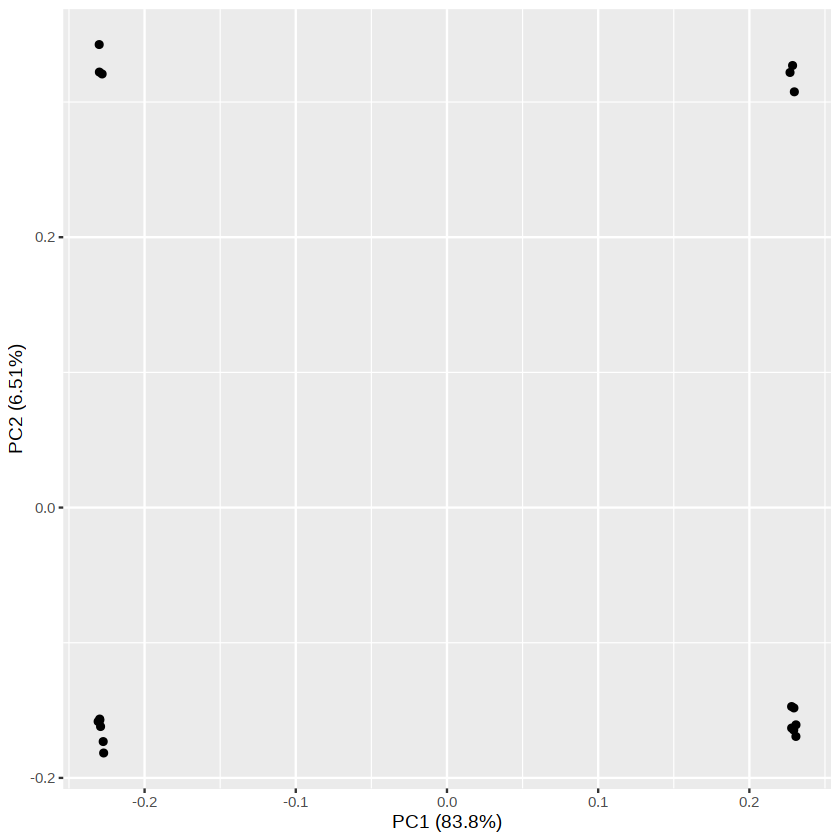

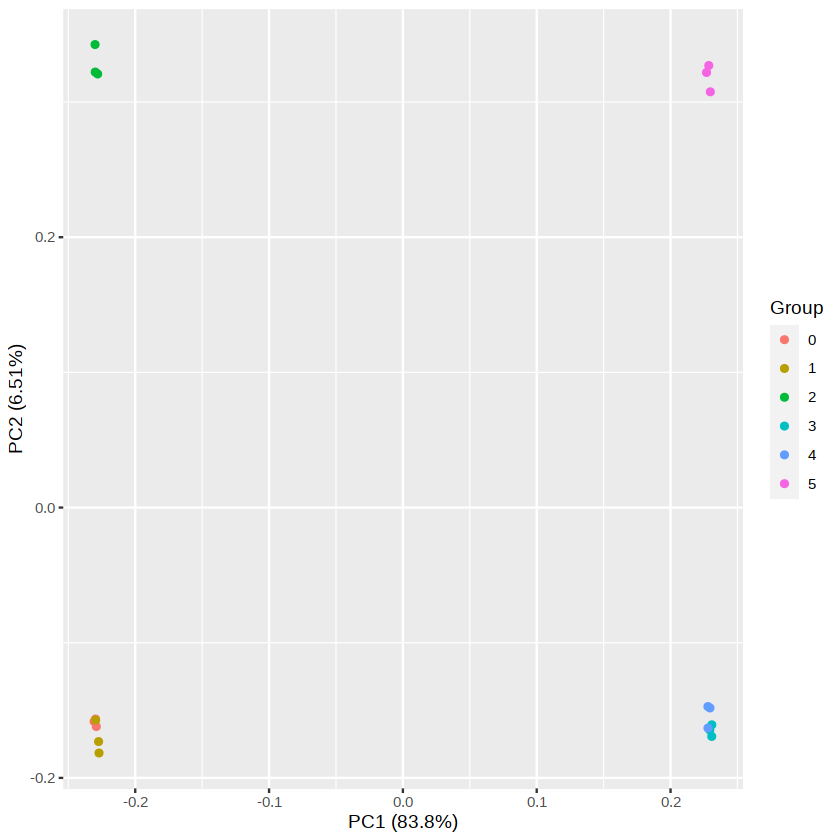

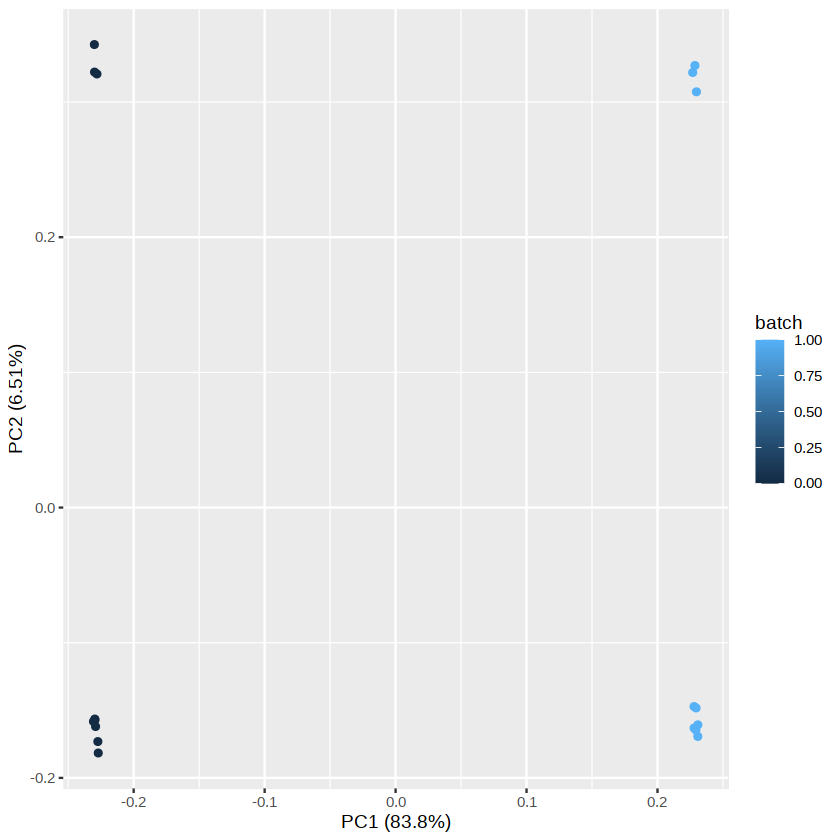

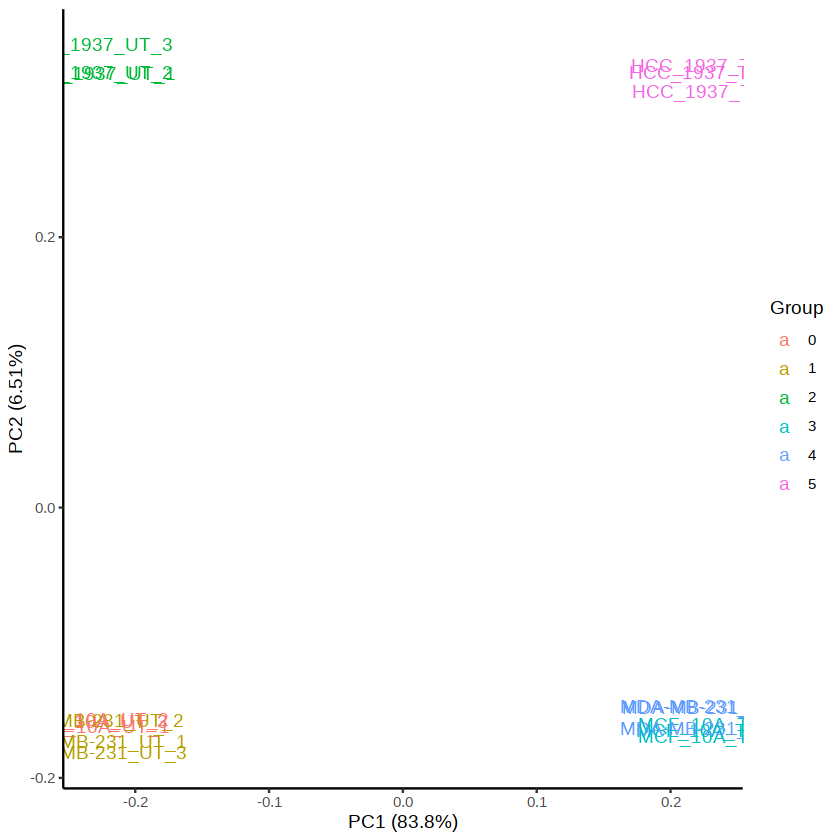

In [8]:
###### Plotting PCA ################
#:::: Before Batch Correction:::::::::::::::

autoplot(prcomp(dat2))
autoplot(prcomp(dat2), data = TMT1, colour = 'Group')
autoplot(prcomp(dat2), data = TMT1, colour = 'batch') # batch not set as a factor so give a gradient plot
rownames(dat2) <- TMT1$Sample
autoplot(prcomp(dat2), data = TMT1, colour = 'Group', shape = FALSE,  label.size = 4) + theme_classic()

### Notice how the third plot shows a range of values for the batch. This is because we did not define batch as a factor in R. 

Warning message:
"package 'edgeR' was built under R version 4.0.3"
Loading required package: limma

Warning message:
"package 'limma' was built under R version 4.0.3"


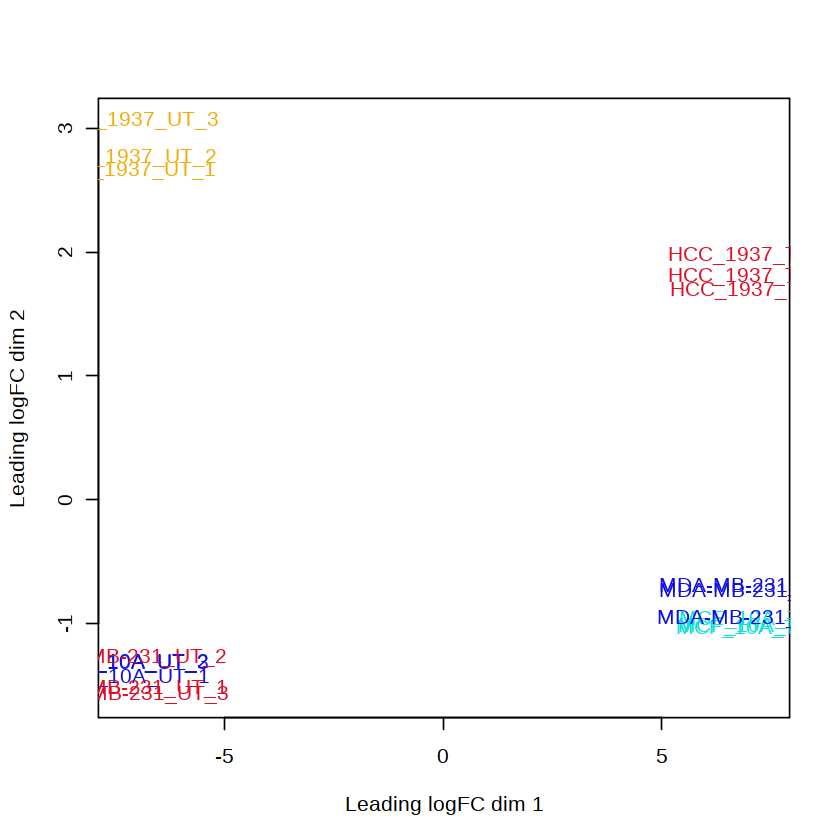

In [9]:
##########################################################
#:::::::::::::: MDS plot from edgeR package
##########################################################
library(edgeR)
col = c(rep(blue,3), rep(red,3), rep(orange,3), rep(green2,3))
plotMDS(t(dat2), labels = TMT1$Sample, col=col)


# Step 2. Differential Abundance Analysis

## Steps for Differential Analysis
1. The normalized protein file is now analyzed using LIMMA. 
2. The LIMMA model includes the sample group as well as any batch effects that need to be corrected
3. A contrast matrix defines the sample group comparisons.
4. lmFit: creates a linear model of the data
5. eBayes: smooths the standard errors

## terms


<b> limma lmfit: </b> Fit linear model for each gene given a series of arrays. The main function for model fitting is lmFit. This is recommended interface for most users. lmFit produces a fitted model object of class MArrayLM containing coefficients, standard errors and residual standard errors for each gene.

<b>Assessing Differential Abundance:</b> After fitting a linear model, the standard errors are moderated using a simple empirical Bayes model using eBayes or treat. A moderated t-statistic and a log-odds of differential expression is computed for each contrast for each gene. 

<b> treat: </b> Tests whether log-fold-changes are greater than a threshold rather than merely different to zero.

<b> eBayes: </b>  Given a linear model fit from lmFit, compute moderated t-statistics, moderated F-statistic, and log-odds of differential expression by empirical Bayes moderation of the standard errors towards a global value 

These functions are used to rank genes in order of evidence for differential expression. They use an
empirical Bayes method to squeeze the genewise-wise residual variances towards a common value
(or towards a global trend) (Smyth, 2004; Phipson et al, 2016). The degrees of freedom for the
individual variances are increased to reflect the extra information gained from the empirical Bayes
moderation, resulting in increased statistical power to detect differential expression.

<p>These functions accept as input an MArrayLM fitted model object fit produced by lmFit. The
columns of fit define a set of contrasts which are to be tested equal to zero. The fitted model
object may have been processed by contrasts.fit before being passed to eBayes to convert the
coefficients of the original design matrix into an arbitrary number of contrasts.</p>

<p> The empirical Bayes moderated t-statistics test each individual contrast equal to zero. For each gene
(row), the moderated F-statistic tests whether all the contrasts are zero. The F-statistic is an overall
test computed from the set of t-statistics for that probe. This is exactly analogous the relationship
between t-tests and F-statistics in conventional anova, except that the residual mean squares have
been moderated between genes.</p>

eBayes does not compute ordinary t-statistics because they always have worse performance than the moderated versions. 

<b>Covariates </b> contain numerical values that are quantitative measurements associated with samples in the experiment. These can be the age or weight of an individual, or other molecular or cellular phenotypes on a sample, such as measurements obtained from a polymerase chain reaction (PCR) experiment or fluorescence activated cell sorting (FACS)

<p>For covariates, it is generally of interest to know the rate of change between the response and the covariate, such as “how much does the expression of a particular gene increase/decrease per unit increase in age?”. We can use a straight line to model, or describe, this relationship, where the line is defined by β0 the y-intercept and β1 the slope.</p>
    
In this model, the age covariate takes continuous, numerical values such as 0.8, 1.3, 2.0, 5.6, and so on.
We refer to this model generally as a <b> regression model </b>, where the slope indicates the rate of change, or how much gene expression is expected to increase/decrease by per unit increase of the covariate. 

<p> The y-intercept and slope of the line, or the βs (β0 and β1), are referred to as the model parameters. 
The true values of the parameters are unknown, but are estimated in the modelling process. </p>

<p> A positive estimate of a model parameter indicates that an explanatory variable has a positive influence on gene expression (an increasing slope), whilst a negative value indicates that the explanatory variable has a negative influence on gene expression (a decreasing slope). </p>

 In some cases, one may convert the age covariate into a factor by categorizing the smaller values as “young” and larger values as “mature”, and instead use the models described below.


<img src="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7873980/bin/f1000research-9-30844-g0000.jpg" alt="model" width="800" height="800">

### Basic models for covariate and factor explanatory variables.
LEFT: The basic model for covariates is referred to as a regression model, which is a line defined by the model parameters β 0 the y-intercept, and β 1 the slope. CENTER: One of two basic models for factors is referred to as a means model, where model parameters are calculated as the mean gene expression of each level of the factor e.g. β 1 represents the mean expression for wildtype and β 2 represents the mean of mutant. RIGHT: The other basic model we refer to for factors is a mean-reference model, where the first model parameter is calculated as the mean gene expression of the reference level, and subsequent parameters are calculated relative to the reference level e.g. β 1 represents the mean expression for wildtype and β 2 represents the difference between mutant and wildtype. In each plot, the points represent the original data; coloured lines are used to represent expected gene expression, where dashed lines are specifically used to represent expected gene expression for non-reference levels in the mean-reference model e.g. mutant.

Reference: Charity Law: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7873980/#!po=6.25000 

## limma design

The choice of design matrix is a critical step in linear modeling since it encodes which coefficients will be fit in the model, as well as the inter-relationship between the samples. 

A common misunderstanding is that the choice of design follows straightforward from a description of which samples were included in the experiment. This is not the case. The basic information about each sample (whether control or treatment group, experimental batch, etc.) does not imply a single ‘correct’ design matrix. The design matrix additionally encodes various assumptions about how the variables in X explain the observed values in Y, on which the investigator must decide. 

The design matrices that we ultimately work with will have at least two columns: an intercept column, which consists of a column of 1’s, and a second column, that specifies which samples are in a second group. In this case, two coefficients are fit in the linear model: the intercept, which represents the population average of the first group, and a second coefficient, which represents the difference between the population averages of the second group and the first group. The latter is typically the coefficient we are interested in when we are performing statistical tests: we want to know if their is a difference between the two groups.

A note about factors: the names of the levels are irrelevant to model.matrix and lm. All that matters is the order. For example:

group <- factor(c("control","control","highfat","highfat"))
model.matrix(~ group)
https://genomicsclass.github.io/book/pages/expressing_design_formula.html

We use a no intercept model and apply the make.contrasts function to allow for sample group comparisons to be defined. 

In [10]:
#############################################################
# :::::::::::: LIMMA 
#############################################################
df <- t(dat2)

vec <- c(rep("control_UT",3),rep("TNBC_WT_UT",3), rep("TNBC_mu_UT",3),rep("control_Tx",3),rep("TNBC_WT_Tx",3), rep("TNBC_mu_Tx",3))
group <- factor(vec, levels=c("control_UT", "TNBC_WT_UT","TNBC_mu_UT","control_Tx", "TNBC_WT_Tx","TNBC_mu_Tx"))

design = model.matrix(~0 + group)
colnames(design) <- levels(group)
design


,control_UT,TNBC_WT_UT,TNBC_mu_UT,control_Tx,TNBC_WT_Tx,TNBC_mu_Tx
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,0,1,0,0,0,0
5,0,1,0,0,0,0
6,0,1,0,0,0,0
7,0,0,1,0,0,0
8,0,0,1,0,0,0
9,0,0,1,0,0,0
10,0,0,0,1,0,0


In [11]:
# To make all pair-wise comparisons between the three groups the appropriate contrast matrix can be created by

contr.matrix = makeContrasts(
  TNBCWT_UTvscontrol =  TNBC_WT_UT - control_UT,
  TNBCmu_UTvscontrol =  TNBC_mu_UT - control_UT,
  TNBCWT_Txvscontrol =  TNBC_WT_Tx - control_Tx,
  TNBCmu_Txvscontrol =  TNBC_mu_Tx - control_Tx,
  levels = colnames(design))
contr.matrix

,TNBCWT_UTvscontrol,TNBCmu_UTvscontrol,TNBCWT_Txvscontrol,TNBCmu_Txvscontrol
control_UT,-1,-1,0,0
TNBC_WT_UT,1,0,0,0
TNBC_mu_UT,0,1,0,0
control_Tx,0,0,-1,-1
TNBC_WT_Tx,0,0,1,0
TNBC_mu_Tx,0,0,0,1


In [12]:
fit <- lmFit(df, design)

cont_fit <- contrasts.fit(fit, contr.matrix)

fit2 <- eBayes(cont_fit)
top10 <- topTable(fit2, coef=1)
top10


Warning message:
"Zero sample variances detected, have been offset away from zero"


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H7C285,11.816220,11.679246,199.29326,1.122525e-23,9.533605e-20,42.90783
Q9BZQ8,4.375328,20.141892,109.61041,2.300661e-20,9.314720e-17,37.01010
H0YF27,10.123616,3.937104,104.96660,3.995226e-20,9.314720e-17,36.51520
F8U8C0,10.771899,9.001739,104.19916,4.387010e-20,9.314720e-17,36.43061
P00533,2.682205,21.993144,98.21994,9.318002e-20,1.468326e-16,35.74236
Q8N139,-12.024745,3.957282,-97.39675,1.037319e-19,1.468326e-16,35.64335
O00592,3.634333,20.894586,95.47153,1.337909e-19,1.623266e-16,35.40756
Q6PGP7,-3.058864,20.152890,-91.35033,2.347814e-19,2.492499e-16,34.88189
P51648,-1.370522,22.528188,-90.47850,2.653006e-19,2.503553e-16,34.76686


In [13]:
results.coef1 <- topTable(fit2, coef=1, number=Inf, sort.by="none")
results.coef2 <- topTable(fit2, coef=2, number=Inf, sort.by="none")
results.coef3 <- topTable(fit2, coef=3, number=Inf, sort.by="none")
results.coef4 <- topTable(fit2, coef=4, number=Inf, sort.by="none")

results.coef <- cbind(results.coef1, results.coef2, results.coef3, results.coef4)

write.csv(results.coef, "Limma_eBayes_results.csv")


In [14]:
summary(decideTests(fit2, method="global"))

       TNBCWT_UTvscontrol TNBCmu_UTvscontrol TNBCWT_Txvscontrol
Down                 2853               3092               2944
NotSig               2579               2179               2448
Up                   3061               3222               3101
       TNBCmu_Txvscontrol
Down                 3174
NotSig               2064
Up                   3255

In [15]:
# Reference: https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf 
# The outcome of each hypothesis test can be assigned using 
results <- decideTests(fit2)
head(results)

,TNBCWT_UTvscontrol,TNBCmu_UTvscontrol,TNBCWT_Txvscontrol,TNBCmu_Txvscontrol
Q13286,0,-1,0,-1
A0A024QZP7,1,-1,1,-1
A0A024QZW4,-1,-1,0,0
A0A024QZX5,-1,-1,0,-1
A0A024R0K5,0,0,0,1
A0A087WTV5,0,0,1,1


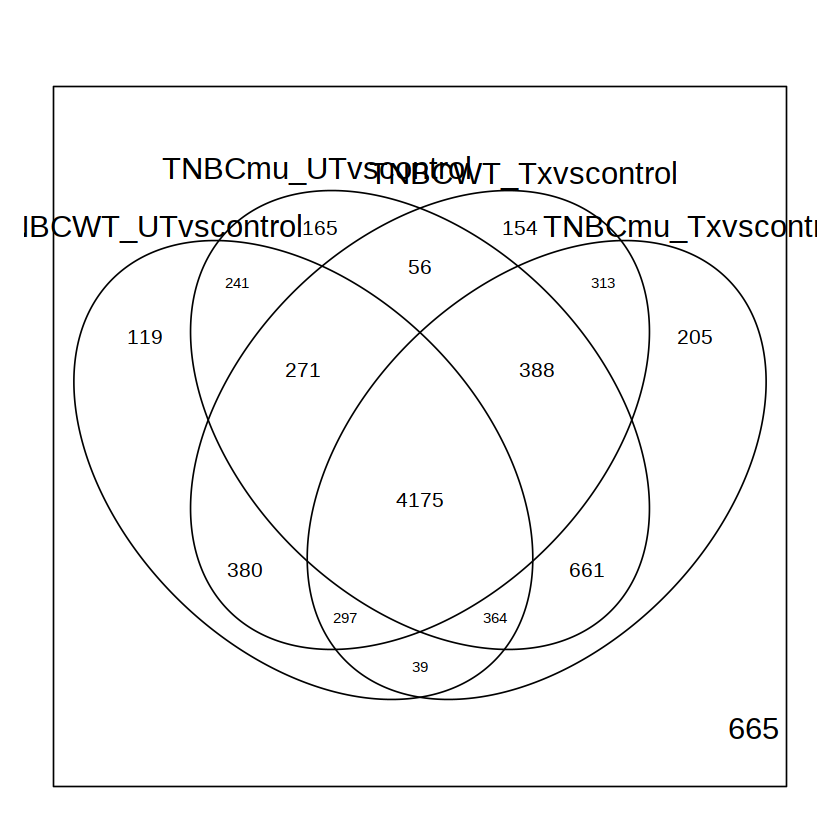

In [16]:
# A Venn diagram showing numbers of genes significant in each comparison can be obtained from

vennDiagram(results)

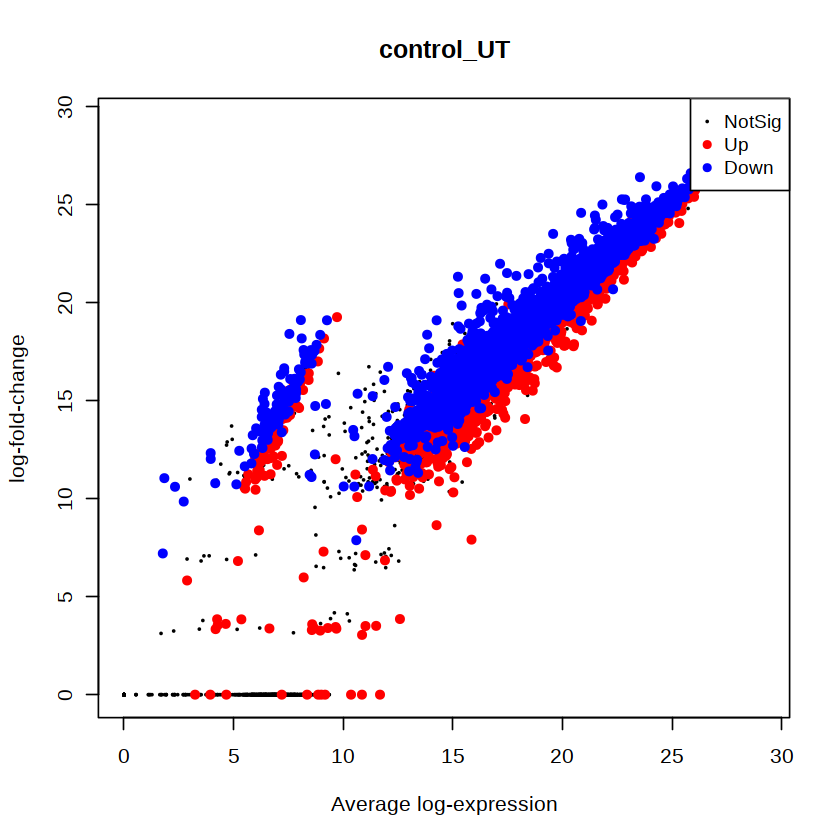

In [17]:
# We can plot the fold-changes for the significant genes: 
plotMD(fit, coef=1, status=results)

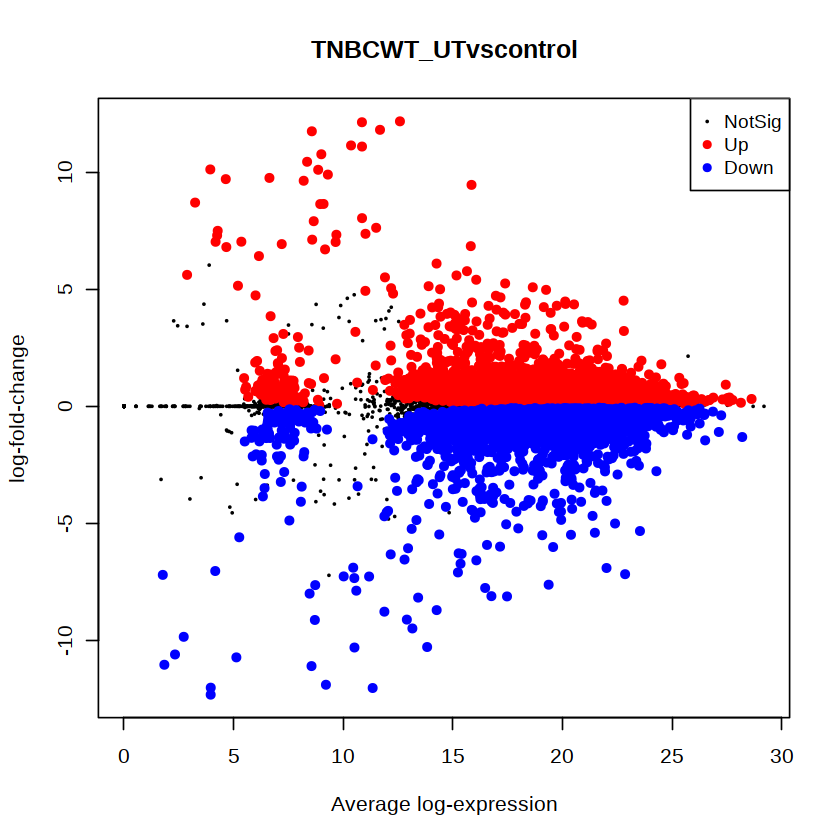

In [18]:
plotMD(fit2, coef=1, status=results)

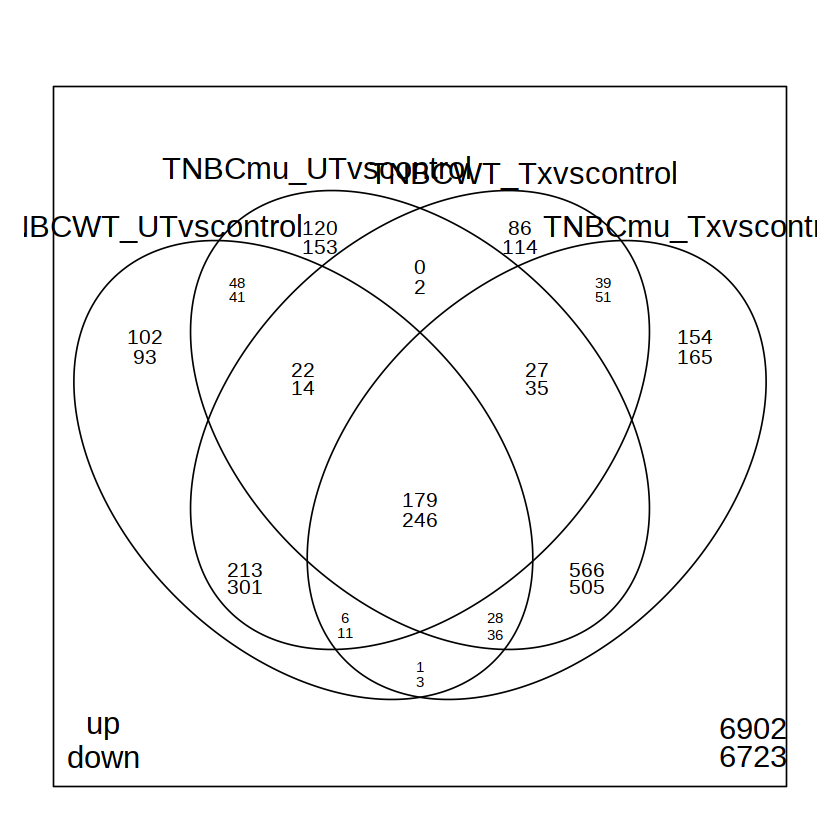

In [19]:
# To find all those proteins that are up-regulated using a 2-fold-change and 5% FDR: 
results <- decideTests(fit2, lfc=1) 
vennDiagram(results, include=c("up","down"))

In [20]:
head(results)

,TNBCWT_UTvscontrol,TNBCmu_UTvscontrol,TNBCWT_Txvscontrol,TNBCmu_Txvscontrol
Q13286,0,0,0,0
A0A024QZP7,0,0,0,0
A0A024QZW4,0,-1,0,0
A0A024QZX5,0,-1,0,0
A0A024R0K5,0,0,0,1
A0A087WTV5,0,0,0,1


In [28]:
i <- 1

png(file.path(".", paste("03_","MD.plot.png",sep="")), units="in", width=5, height=5, res=1000, pointsize=10)
{
     ##----------------------------------------------------------------------------
     op <- par(no.readonly = TRUE)  # save current par settings b4 plotting
     #par(mfrow = c(4, 5))          # multiple plots
     par(mar = c(5, 5, 4, 1))       # inner margin (bottom, left, top, right)
     par(mgp = c(3, 1, 0))          # axis margin (labels, ticks, line)
     par(oma = c(2, 1, 0, 1))       # outer margin (bottom, left, top, right)
     ##----------------------------------------------------------------------------
     plotMD(fit2, column=i, cex=1, las=1, status=results[,i], values=c(1,-1), col=c("red","blue"), 
            legend="topright", main="", 
            xlab=expression(paste("avg. ", log[2]," (counts-per-million)",sep="")),
            ylab=expression(paste(log[2]," (fold-change)",sep="")),
            cex.axis=1.1, cex.lab=1.2
            # ,ylim=c(-11,13)
            #,xlim=c(2,14)
     )
     title(main=paste("MD plot: ", "EPZ vs. CON", "", sep=""))
     legend("topright", c("up", "not sig.", "down"), inset=0, pch=19,
            box.col="black", box.lwd=1, bg="white",
            col=c("red","black","blue"), ncol=1, cex=1)
     
     # text(x=12, y=-3, label=paste("up =", summary(dt)[3], sep=" "), adj=0, col="red", cex=0.9, font=1)
     # text(x=12, y=-4, label=paste("not sig. =", summary(dt)[2], sep=" "), adj=0, col="black", cex=0.9, font=1)
     # text(x=12, y=-5, label=paste("down =", summary(dt)[1], sep=" "), adj=0, col="blue", cex=0.9, font=1)
     abline(h=c(-1,1), col="black", lty=2,lwd=1)
}


dev.off()

png 
  2

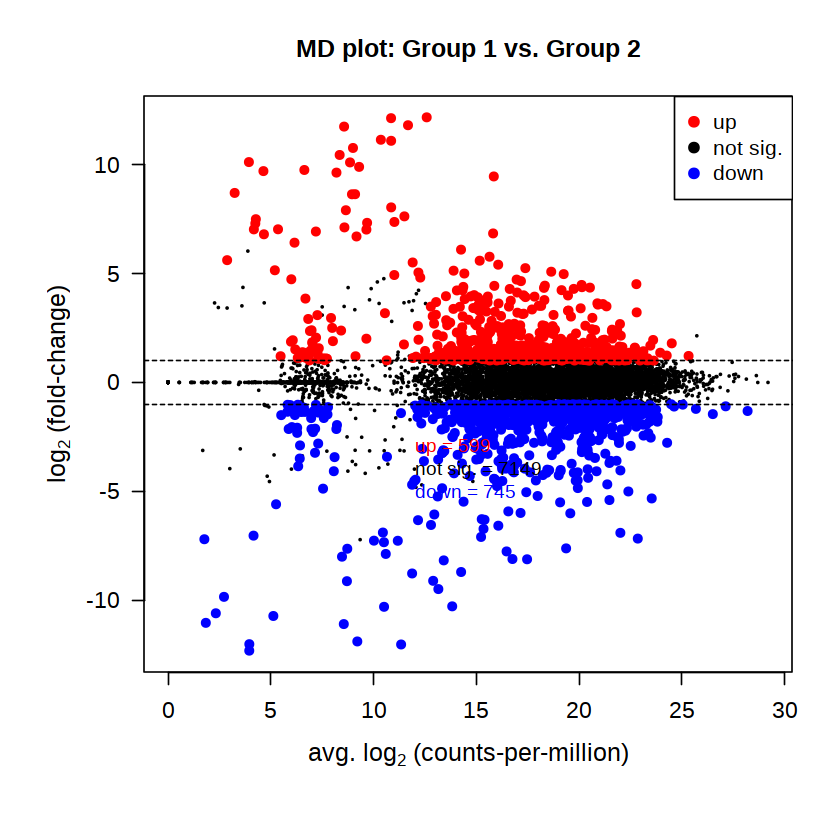

In [30]:
  ##----------------------------------------------------------------------------
     op <- par(no.readonly = TRUE)  # save current par settings b4 plotting
     #par(mfrow = c(4, 5))          # multiple plots
     par(mar = c(5, 5, 4, 1))       # inner margin (bottom, left, top, right)
     par(mgp = c(3, 1, 0))          # axis margin (labels, ticks, line)
     par(oma = c(2, 1, 0, 1))       # outer margin (bottom, left, top, right)
     ##----------------------------------------------------------------------------

plotMD(fit2, column=1, cex=1, las=1, status=results[,1], values=c(1,-1), col=c("red","blue"), 
            legend="topright", main="", 
            xlab=expression(paste("avg. ", log[2]," (counts-per-million)",sep="")),
            ylab=expression(paste(log[2]," (fold-change)",sep="")),
            cex.axis=1.1, cex.lab=1.2
            # ,ylim=c(-11,13)
            #,xlim=c(2,14)
     )
     title(main=paste("MD plot: ", "Group 1 vs. Group 2", "", sep=""))
     legend("topright", c("up", "not sig.", "down"), inset=0, pch=19,
            box.col="black", box.lwd=1, bg="white",
            col=c("red","black","blue"), ncol=1, cex=1)
     
      text(x=12, y=-3, label=paste("up =", summary(results)[3], sep=" "), adj=0, col="red", cex=0.9, font=1)
      text(x=12, y=-4, label=paste("not sig. =", summary(results)[2], sep=" "), adj=0, col="black", cex=0.9, font=1)
      text(x=12, y=-5, label=paste("down =", summary(results)[1], sep=" "), adj=0, col="blue", cex=0.9, font=1)
     abline(h=c(-1,1), col="black", lty=2,lwd=1)

In [ ]:
###############################
## ComplexHeatmap
######################################

library(ComplexHeatmap)
library(colorspace)
library(circlize)


In [ ]:
# select top significant


h.2 <- Heatmap(dat2, name = "Log2 iBAQ", 
               column_title = "FDR corrected p-value <0.05", column_title_side = "top",  
               column_title_gp = gpar(fontsize=9),
               row_title = "Proteins",na_col = "grey",
               row_title_gp = gpar(fontsize=9),
               #col = colorRamp2(c(-2, 5, 10, 15, 20, 25),
               #    c("lightblue","lightblue1","hotpink","deeppink","deeppink4")),
               #c("yellow","green", "lightblue","lightblue1","blue", "red")),
               col = rev(rainbow(10)),
               cluster_rows = TRUE,
               show_row_names=TRUE,
               row_names_gp = gpar(fontsize = 9),
               clustering_distance_rows = "euclidean",
               clustering_method_rows = "complete",
               cluster_columns = TRUE,
               column_names_gp = gpar(fontsize = 7),
               clustering_distance_columns = "euclidean",
               clustering_method_columns = "complete")
# km=2,km_title = "C%i",
# top_annotation_height = unit (0.25, "cm"),
# top_annotation = ha2.top,
# bottom_annotation = ha2.bottom,
# bottom_annotation_height = unit(4, "cm"))
h.2


## References

1. Hu A, Noble WS, Wolf-Yadlin A. Technical advances in proteomics: new developments in data-independent acquisition. F1000Res. 2016;5(F1000 Faculty Rev):419. doi: 10.12688/f1000research.7042.1.

2. Kawashima Y, Watanabe E, Umeyama T, et al. Optimization of data-independent acquisition mass spectrometry for deep and highly sensitive proteomic analysis. Int. J. Mol. Sci. 2019;20(23):E5932. doi: 10.3390/ijms20235932.

3. Bruderer R, Bernhardt OM, Gandhi T, et al. Optimization of experimental parameters in data-independent mass spectrometry significantly increases depth and reproducibility of results. Mol Cell Proteomics. 2017;16(12):2296–2309. doi: 10.1074/mcp.RA117.000314.

4. Storey AJ, Naceanceno KS, Lan RS, et al. ProteoViz: a tool for the analysis and interactive visualization of phosphoproteomics data. Mol Omics. 2020;16(4):316-326. doi:10.1039/c9mo00149b

5. Graw S, Tang J, Zafar MK, et al. proteiNorm - A User-Friendly Tool for Normalization and Analysis of TMT and Label-Free Protein Quantification. ACS Omega. 2020;5(40):25625-25633. Published 2020 Sep 30. doi:10.1021/acsomega.0c02564

6. Law CW, Zeglinski K, Dong X, Alhamdoosh M, Smyth GK, Ritchie ME. A guide to creating design matrices for gene expression experiments. F1000Res. 2020;9:1444. Published 2020 Dec 10. doi:10.12688/f1000research.27893.1
